In [39]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.pvcnn import PVCNNPartSeg, PVCNN

In [3]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


In [4]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(2832, 405, 808)

In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [7]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [27]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")

In [9]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise/PVCNN-Part-Segmentation-Noise-e69.pth"))

<All keys matched successfully>

In [28]:
for batch in train_dataloader:
    input = batch["train_points"].to("cuda")
    break

In [36]:
input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
input.shape, input_seg.shape

(torch.Size([20, 2048, 3]), torch.Size([20, 2048]))

In [37]:
class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
class_labels_one_hot.shape

torch.Size([20, 2048, 4])

In [38]:
combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)

print(combined_tensor.shape)  # 

torch.Size([20, 2048, 7])


torch.Size([1, 912, 4]) torch.Size([1, 912, 1])
torch.Size([1, 912, 4])
torch.Size([1, 655, 4]) torch.Size([1, 655, 1])
torch.Size([1, 655, 4])
torch.Size([1, 297, 4]) torch.Size([1, 297, 1])
torch.Size([1, 297, 4])
torch.Size([1, 184, 4]) torch.Size([1, 184, 1])
torch.Size([1, 184, 4])
torch.Size([1, 2048, 3]) torch.Size([1, 2048, 3])
tensor(0.6470, device='cuda:0', grad_fn=<DivBackward0>)


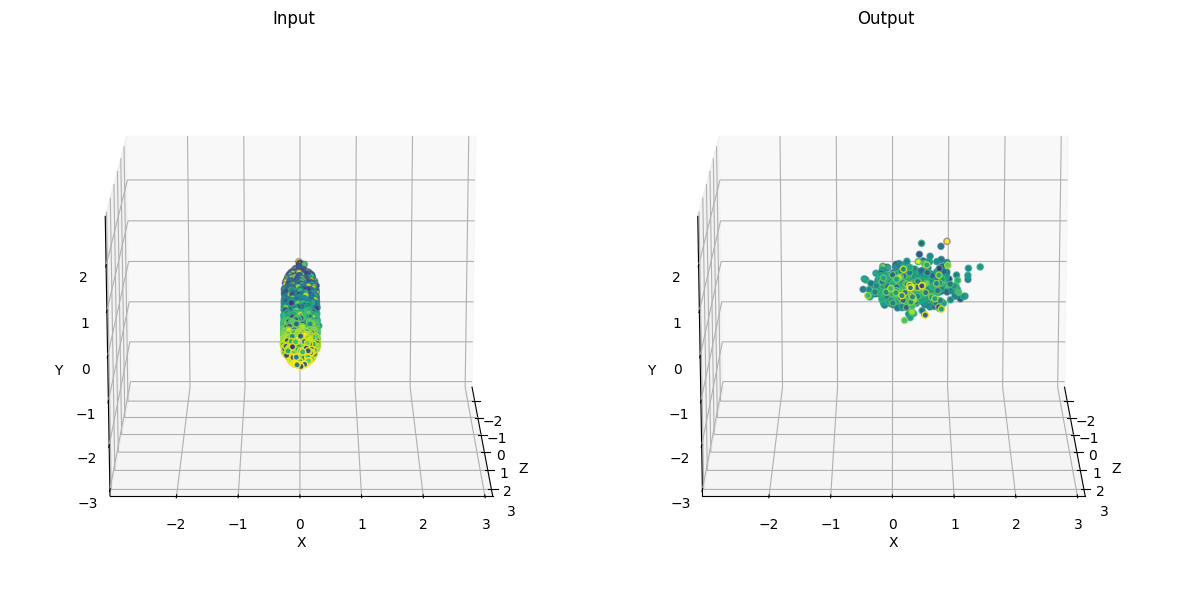

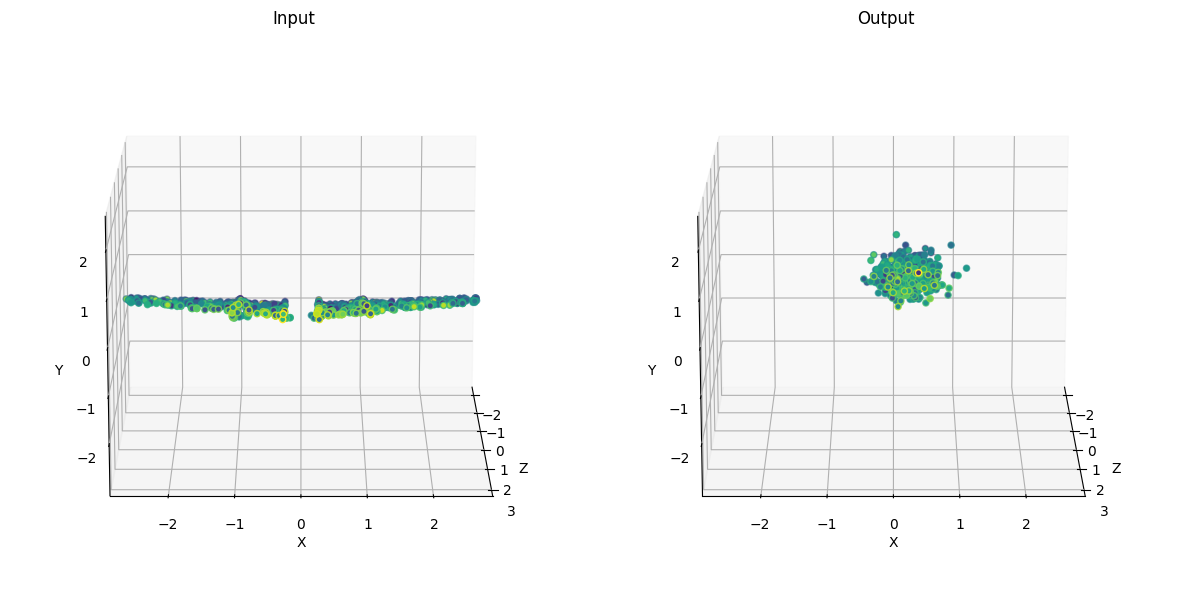

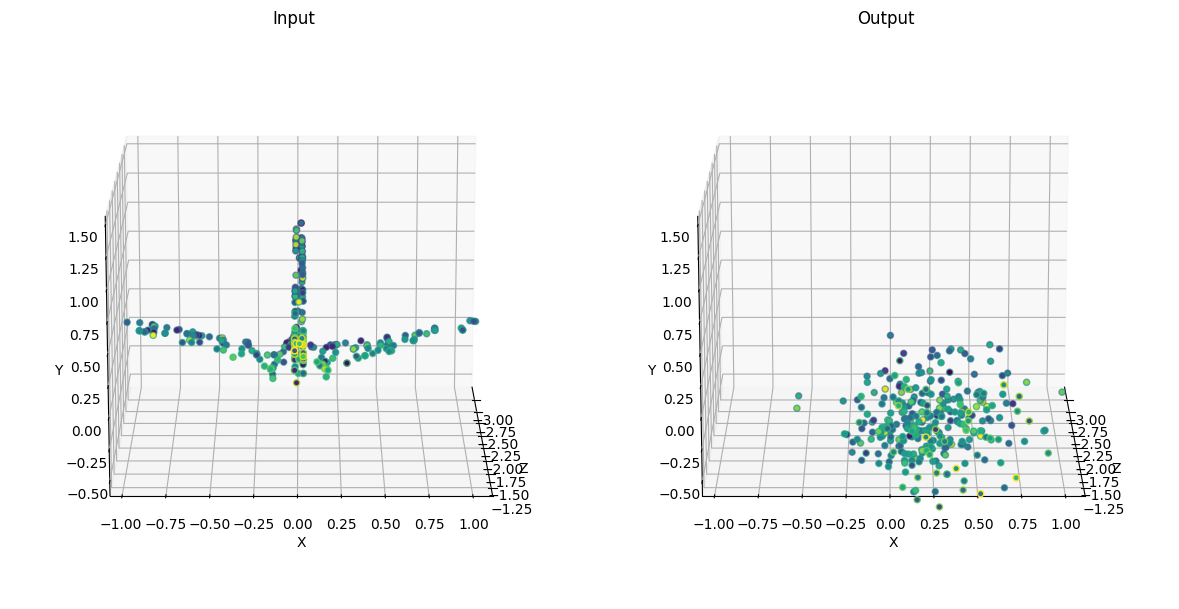

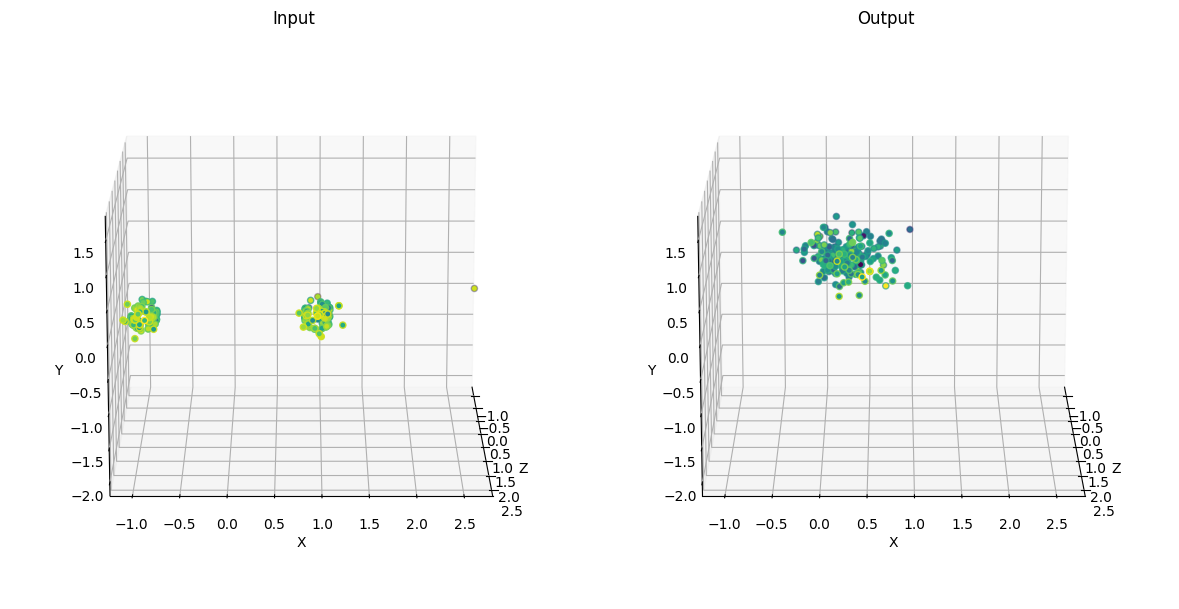

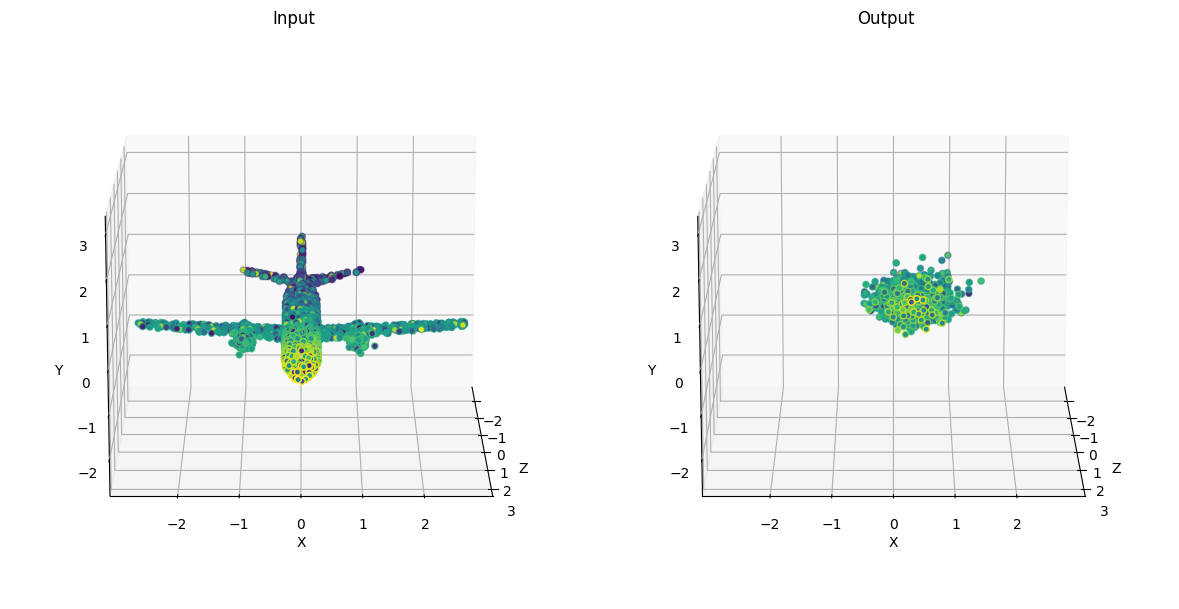

In [12]:
output_batch = []
for sample, seg in zip(input, input_seg):
    output_tensor = torch.zeros_like(sample)

    for i in range(seg.max() + 1):
        part_input = sample[seg == i, :]

        # If the segmeneted part has less than 64 points we don't refine it.
        if part_input.shape[0] < 64:
            output_tensor[seg == i, :] = sample[seg == i, :]
            continue

        part_input_m = part_input.unsqueeze(0)
        class_tensor = torch.full(
            [part_input_m.shape[0], part_input_m.shape[1], 1], i
        ).to("cuda")
        part_input_m = torch.cat([part_input_m, class_tensor], dim=2)

        print(part_input_m.shape, class_tensor.shape)

        print(part_input_m.shape)

        output = model(part_input_m.transpose(1, 2))

        fig = visualize_pointcloud_eval(
            part_input.detach().cpu().numpy(),
            output.squeeze().transpose(0, 1).detach().cpu().numpy(),
            "Input",
            "Output",
        )

        output_tensor[seg == i, :] = output.squeeze().transpose(0, 1)

    fig = visualize_pointcloud_eval(
        sample.detach().cpu().numpy(),
        output_tensor.detach().cpu().numpy(),
        "Input",
        "Output",
    )
    print(output_tensor.unsqueeze(0).shape, sample.unsqueeze(0).shape)
    print(chamfer_distance(output_tensor.unsqueeze(0), sample.unsqueeze(0)))
    break

In [44]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Part-Class-Condition'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [45]:
# Time to train
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")
        
        noised_input = add_random_noise(input)
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)

        optimizer.zero_grad()
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)

        output = model(combined_tensor.transpose(1,2)).transpose(1,2)

        loss = chamfer_distance(input, output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Epoch is done; Reduce LR
    lr_scheduler.step()

    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")
            
            # Let's first add noise
            noised_input = add_random_noise(input)

            # Let's segment the input into parts and extract the part assignment.
            input_seg = part_model(noised_input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)
            
            # Classes in one extra feature
            # classes_input = torch.cat([noised_input, input_seg], dim=2)
            # output = model(classes_input.transpose(1,2)).transpose(1,2)

            # Normal
            # output = model(noised_input.transpose(1,2)).transpose(1,2)

            # One hot encoded
            class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
            combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)
            output = model(combined_tensor.transpose(1,2)).transpose(1,2)

            val_loss = chamfer_distance(input, output)
            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-part-class/PVCNN-Baseline-Refinement-Part-Class-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0359, Validation Loss: 0.2538
Epoch 2,  Training Loss: 0.0160, Validation Loss: 0.2026
Epoch 3,  Training Loss: 0.0122, Validation Loss: 0.1862
Epoch 4,  Training Loss: 0.0104, Validation Loss: 0.1822
Epoch 5,  Training Loss: 0.0093, Validation Loss: 0.1854
No improvement in validation loss for 1 epochs.
Epoch 6,  Training Loss: 0.0085, Validation Loss: 0.1885
No improvement in validation loss for 2 epochs.
Epoch 7,  Training Loss: 0.0081, Validation Loss: 0.1831
No improvement in validation loss for 3 epochs.
Epoch 8,  Training Loss: 0.0077, Validation Loss: 0.1849
No improvement in validation loss for 4 epochs.
Epoch 9,  Training Loss: 0.0073, Validation Loss: 0.1831
No improvement in validation loss for 5 epochs.
Epoch 10,  Training Loss: 0.0071, Validation Loss: 0.1833
No improvement in validation loss for 6 epochs.
Epoch 11,  Training Loss: 0.0068, Validation Loss: 0.1784
Epoch 12,  Training Loss: 0.0065, Validation Loss: 0.1788
No improvement in validat

In [10]:
import pandas as pd

df_train = pd.read_csv("./eval-results/pvcnn-refinement-part-run-train-loss.csv")
df_val = pd.read_csv("./eval-results/pvcnn-refinement-part-run-val-loss.csv")

training_losses = df_train["Value"].to_numpy()
val_losses = df_val["Value"].to_numpy()

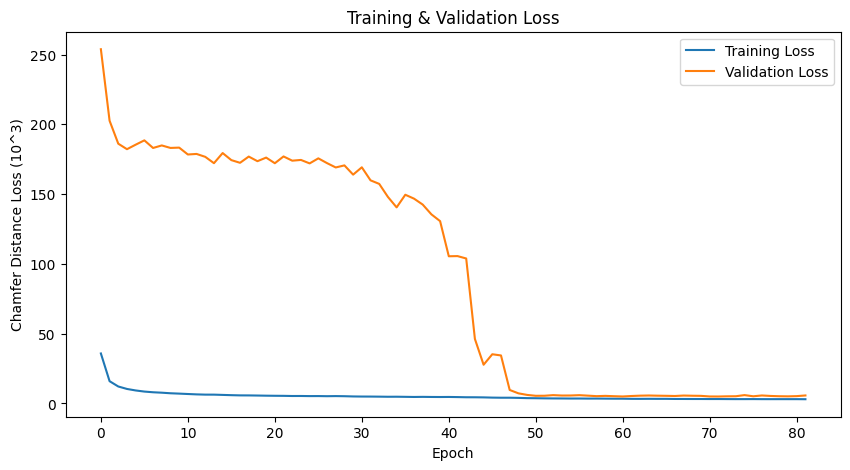

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(training_losses) * (10**3), label='Training Loss')
plt.plot(np.array(val_losses) * (10**3), label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss (10^3)')
plt.legend()
plt.show()

In [20]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Loss: {np.min(training_losses)* (10**3):.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Loss: {np.min(val_losses) * (10**3):.4f}")

Best Train Loss: Epoch: 14, Loss: 7.8857
Best Val Loss: Epoch: 4, Loss: 22.5718


In [57]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load(f"output-models/pvcnn-refinement-part/PVCNN-Baseline-Refinement-Part-e{np.argmax(val_losses)+1}.pth"))

<All keys matched successfully>

In [102]:
# Test
total_test_loss = 0
batch_i=1

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        
        test_loss = chamfer_distance(input, output)
        total_test_loss += test_loss.item()
        print(f"Batch: {batch_i}; CD Loss: {test_loss.item() * 10**3:.4f}")
        batch_i+=1

avg_total_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_total_loss * 10**3:.4f}")

Batch: 1; CD Loss: 6.4138
Batch: 2; CD Loss: 7.0517
Batch: 3; CD Loss: 7.8218
Batch: 4; CD Loss: 6.5128
Batch: 5; CD Loss: 7.0978
Batch: 6; CD Loss: 8.1786
Batch: 7; CD Loss: 6.5792
Batch: 8; CD Loss: 6.6041
Batch: 9; CD Loss: 6.3749
Batch: 10; CD Loss: 5.8772
Batch: 11; CD Loss: 7.5616
Batch: 12; CD Loss: 5.5967
Batch: 13; CD Loss: 6.0705
Batch: 14; CD Loss: 7.9629
Batch: 15; CD Loss: 6.5176
Batch: 16; CD Loss: 6.0327
Batch: 17; CD Loss: 6.3510
Batch: 18; CD Loss: 8.0491
Batch: 19; CD Loss: 6.8817
Batch: 20; CD Loss: 6.2005
Batch: 21; CD Loss: 7.3832
Batch: 22; CD Loss: 6.9599
Batch: 23; CD Loss: 8.1147
Batch: 24; CD Loss: 6.9864
Batch: 25; CD Loss: 6.5290
Batch: 26; CD Loss: 7.2255
Batch: 27; CD Loss: 7.0391
Batch: 28; CD Loss: 6.4716
Batch: 29; CD Loss: 7.0252
Batch: 30; CD Loss: 7.0229
Batch: 31; CD Loss: 6.6229
Batch: 32; CD Loss: 8.1547
Batch: 33; CD Loss: 8.3305
Batch: 34; CD Loss: 7.6572
Batch: 35; CD Loss: 7.5904
Batch: 36; CD Loss: 6.3298
Batch: 37; CD Loss: 7.7685
Batch: 38;

In [124]:
INDEX = 4
input_pc = input[INDEX, ...].detach().cpu().numpy()
output_pc = output[INDEX, ...].detach().cpu().numpy()
input_pc.shape, output_pc.shape

((2048, 3), (2048, 3))

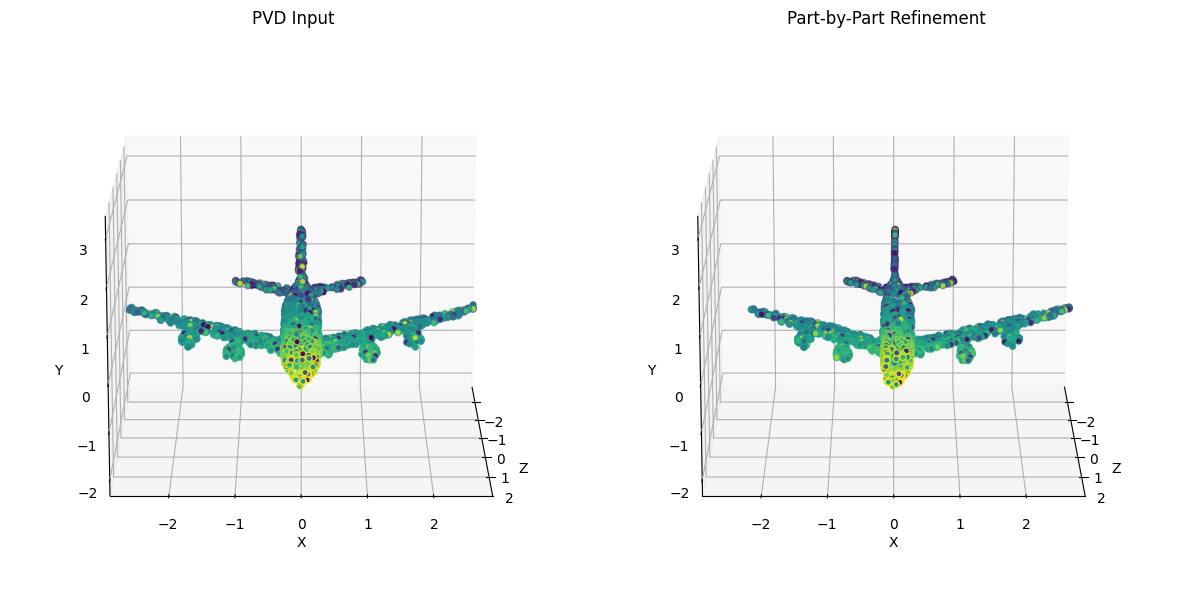

In [125]:
fig = visualize_pointcloud_eval(input_pc, output_pc, "PVD Input", "Part-by-Part Refinement")

(733, 3) 1.8352904
(954, 3) 6.431833
(286, 3) 1.8690019
(75, 3) 1.8180596


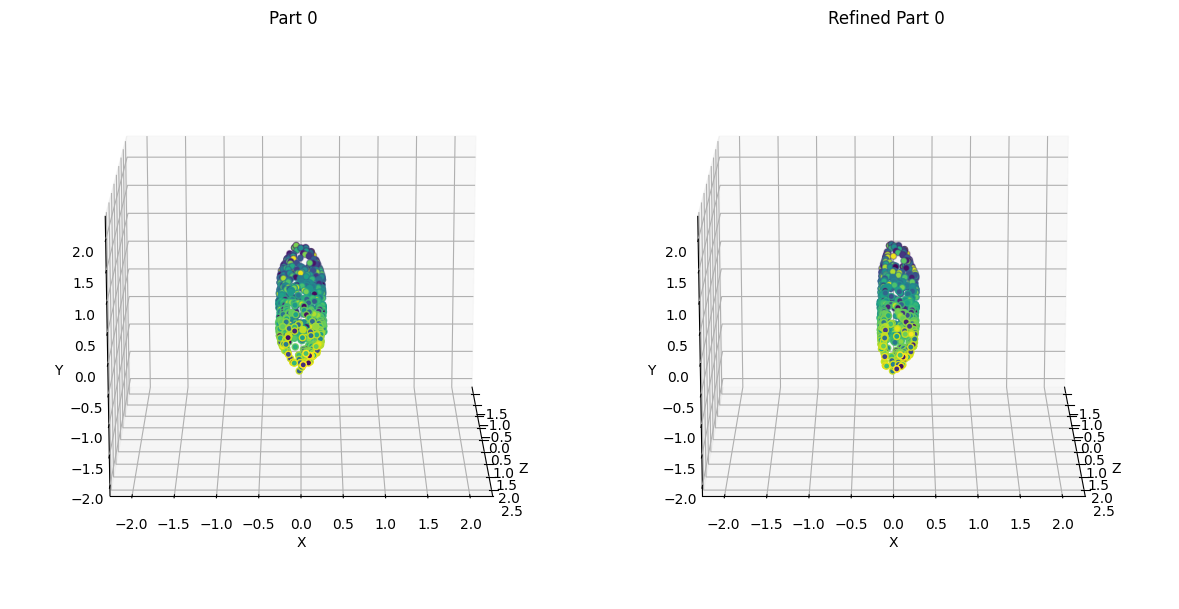

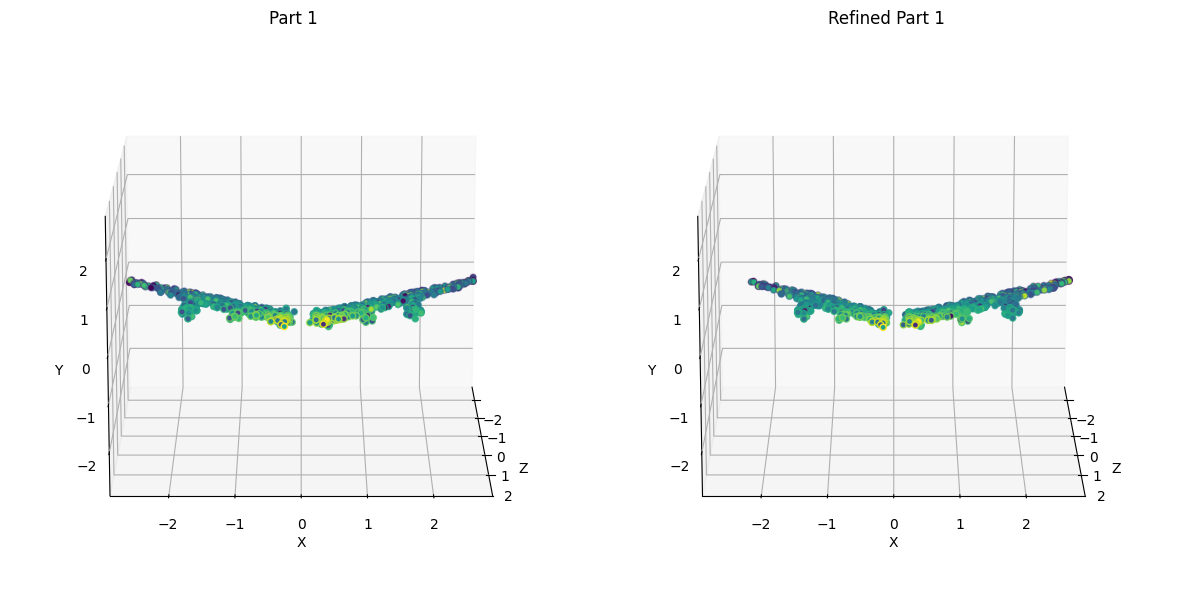

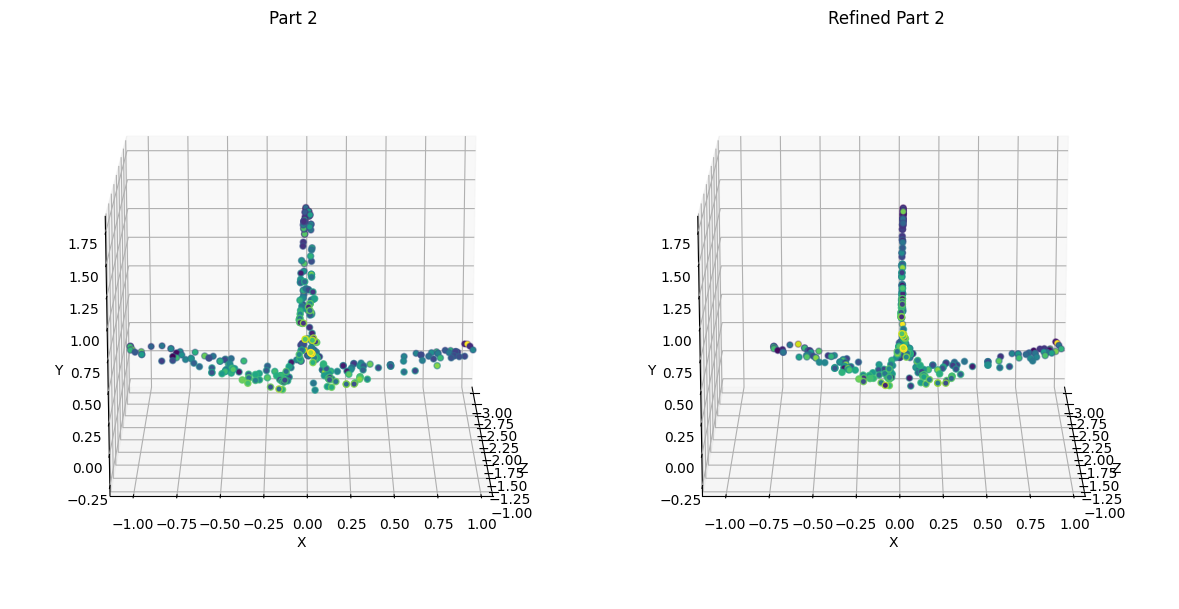

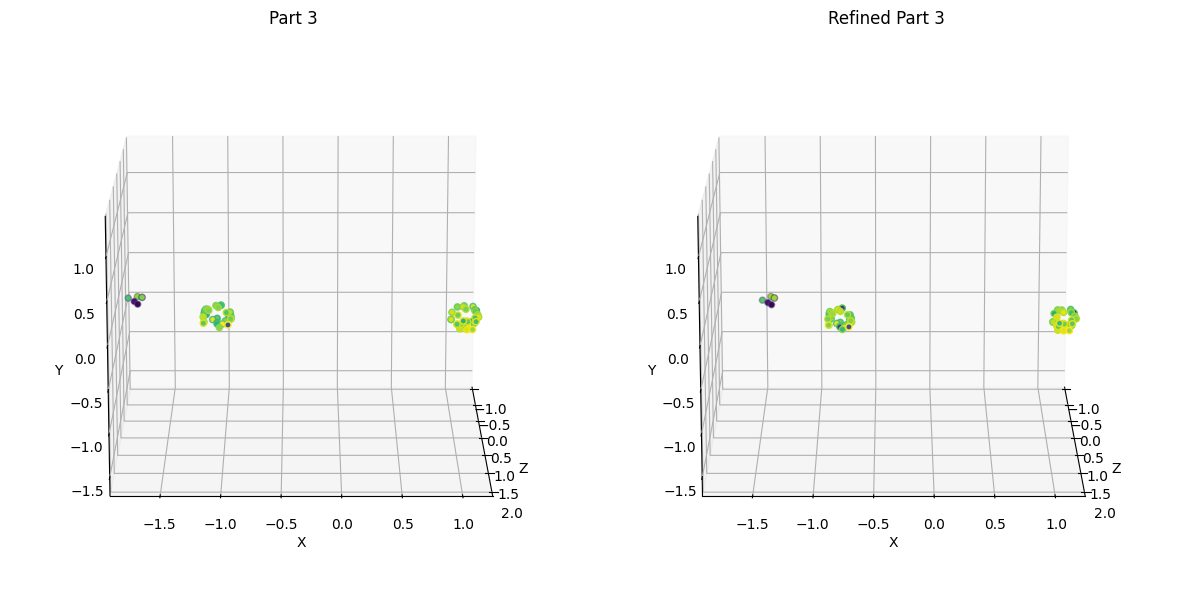

In [127]:
input_part_seg = input_seg[INDEX, ...]

# One hot encoded
class_labels_one_hot = F.one_hot(input_part_seg, num_classes=4)
combined_tensor = torch.cat((input[INDEX, ...], class_labels_one_hot), dim=-1)
output_part = model(combined_tensor.unsqueeze(0).transpose(1,2)).transpose(1,2).squeeze(0)

for i in range(input_part_seg.max()+1):
    refined_np = output_part[input_part_seg == i].detach().cpu().numpy()
    pc_part = input[INDEX, input_part_seg == i, ...].detach().cpu().numpy()
    print(pc_part.shape, np.linalg.norm(pc_part - refined_np))

    fig = visualize_pointcloud_eval(pc_part, refined_np, f"Part {i}", f"Refined Part {i}")

In [53]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [54]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [61]:
# Evaluation
output_array = []

model.eval()
with torch.no_grad():
    for batch in dataloader_pvd:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        output_array.append(output)
        

In [64]:
input_pcs = torch.stack(input_array).view(400, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 2048, 3]), torch.Size([400, 2048, 3]))

In [66]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


100%|██████████| 400/400 [03:42<00:00,  1.80it/s]

{'lgan_mmd-CD': 0.07427497208118439, 'lgan_cov-CD': 0.3149999976158142, 'lgan_mmd_smp-CD': 0.02809010073542595, 'lgan_mmd-EMD': 0.6196457147598267, 'lgan_cov-EMD': 0.3149999976158142, 'lgan_mmd_smp-EMD': 0.3524820804595947, '1-NN-CD-acc_t': 0.8949999809265137, '1-NN-CD-acc_f': 0.9700000286102295, '1-NN-CD-acc': 0.9325000047683716, '1-NN-EMD-acc_t': 0.8424999713897705, '1-NN-EMD-acc_f': 0.9225000143051147, '1-NN-EMD-acc': 0.8824999928474426}


In [ ]:
result = {
    'lgan_mmd-CD': 0.07427497208118439, 
    'lgan_cov-CD': 0.3149999976158142, 
    'lgan_mmd_smp-CD': 0.02809010073542595, 
    'lgan_mmd-EMD': 0.6196457147598267, 
    'lgan_cov-EMD': 0.3149999976158142, 
    'lgan_mmd_smp-EMD': 0.3524820804595947, 
    '1-NN-CD-acc_t': 0.8949999809265137, 
    '1-NN-CD-acc_f': 0.9700000286102295, 
    '1-NN-CD-acc': 0.9325000047683716, 
    '1-NN-EMD-acc_t': 0.8424999713897705, 
    '1-NN-EMD-acc_f': 0.9225000143051147, 
    '1-NN-EMD-acc': 0.8824999928474426
}
